# 1. Install dependencies

1. On windows, after installing Anaconda:     

Open the Anaconda command window and run the following commands to install the necessary libraries

pip install rasterio  
pip install geopandas 

If necessary, you can find out more about installing rasterio and geopandas here: 
https://rasterio.readthedocs.io/en/latest/installation.html    
https://geopandas.org/en/stable/getting_started/install.html

2. clone CCA_EU from https://github.com/JingyanYu/LandUseDecisions/blob/9bd4747ca46c199b63d7936d16e259e46afff9ec/A%20data-driven%20framework%20to%20manage%20uncertainty/CCA_EU.py

In [113]:
import rasterio as rio
from rasterio.plot import show

In [114]:
import geopandas as gpd

In [115]:
import CCA_EU

In [116]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# 2. FUA, GHSL data

The GHSL built-up raster data publicly available with identifiers doi: 10.2905/jrc-ghsl-10007    
Functional urban area vector data: https://ghsl.jrc.ec.europa.eu/ghs_fua.php

The processed GeoDataFrame of European functional urban areas & growth - the file countries_gpd.pkl can be downloaded at https://figshare.com/s/245ad30270bd7eb12f41. After downloading the files, copy to a (new) "pickled_data" folder.

In [ ]:
# Load a geodataframe of functional urban areas (FUAs) in European OECD countries 
# with units of built-up urban growth between 1975-2014 

countries_gpd = pd.read_pickle(r"pickled_data\countries_gpd.pkl")
FUAs = countries_gpd['eFUA_name'].to_list()
countries = countries_gpd['Cntry_name'].to_list()

In [6]:
countries_gpd.head()

,eFUA_name,Cntry_name,FUA_area,UC_area,geometry,1975 urban,1990 urban,2000 urban,2014 urban,90-00 UG,00-14 UG,75-90 UG
252,Innsbruck,Austria,352.0,27.0,"MULTIPOLYGON (((914000.000 5590000.000, 916000...",855.0,957,1078,1173,121,95,102.0
253,Salzburg,Austria,368.0,46.0,"MULTIPOLYGON (((1031000.000 5652000.000, 10320...",1015.0,1114,1266,1421,152,155,99.0
254,Linz,Austria,875.0,69.0,"MULTIPOLYGON (((1116000.000 5708000.000, 11250...",1908.0,2214,2555,2879,341,324,306.0
255,Klagenfurt,Austria,462.0,26.0,"MULTIPOLYGON (((1139000.000 5531000.000, 11400...",847.0,967,1027,1167,60,140,120.0
256,Graz,Austria,978.0,73.0,"MULTIPOLYGON (((1206000.000 5582000.000, 12070...",1420.0,1440,1743,1930,303,187,20.0


# 3. Use CCA

The reclassified maps can be found at: https://figshare.com/s/406b4f8506dfdb80e9b6

The parameters by scenarios can be found at: https://doi.org/10.6084/m9.figshare.22194244.v1

After downloading, copy the parameters to a "parameters" folder and the pkl files to the "pickled_data" folder.

In [7]:
# Load fact maps of functional urban areas, binarily classified with urban, non-urban land uses
with open(r'pickled_data\categorized_FUA_1975s.pickle', 'rb') as handle:
    categorized_FUA_1975s = pickle.load(handle)
with open(r'pickled_data\categorized_FUA_1990s.pickle', 'rb') as handle:
    categorized_FUA_1990s = pickle.load(handle)
# with open(r'pickled_data\categorized_FUA_2000s.pickle', 'rb') as handle:
#     categorized_FUA_2000s = pickle.load(handle)
# with open(r'pickled_data\categorized_FUA_2014s.pickle', 'rb') as handle:
#     categorized_FUA_2014s = pickle.load(handle)

In [110]:
# Load the parameters for urban spatial development scenarios projection

# paths = [ r'parameters\Avignon_m_chain2.npy',r'parameters\Poitiers_m_chain2.npy',
#          r'parameters\Belfast_m_chain2.npy',r'parameters\Blackwater_m_chain2.npy',
#          r'parameters\Enschede_m_chain2.npy',r'parameters\Utrecht_m_chain2.npy',
#          r'parameters\Leuven_m_chain2.npy',r'parameters\Mons_m_chain2.npy', 
#          r'parameters\Mönchengladbach_m_chain2.npy',r'parameters\Wuppertal_m_chain2.npy']

# chains = [np.load(path,allow_pickle=True) for path in paths]
# paras_best20 = [chain[0][chain[2].argsort()[:20]] for chain in chains]
# seeds_best20 = [chain[1][chain[2].argsort()[:20]] for chain in chains]

paras_fourscenarios = np.load(r'pickled_data\paras_fourscenarios.npy',allow_pickle=True)
seeds_fourscenarios = np.load(r'pickled_data\seeds_fourscenarios.npy',allow_pickle=True)

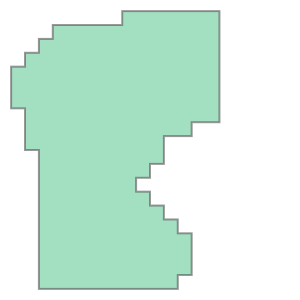

In [9]:
# The FUA polygon of Margate, UK
index_of_margate = 649
countries_gpd.iloc[index_of_margate].geometry

In [10]:
#75-90 growth of Margate, UK

growth_num7590 = countries_gpd.iloc[index_of_margate]['75-90 UG']
growth_num7590

33.0

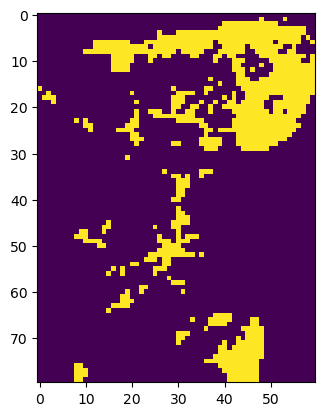

<AxesSubplot:>

In [11]:
# The urban area (cells/pixels) of Margate, UK
fua_1975 = categorized_FUA_1975s[index_of_margate].copy()
fua_1975[fua_1975==-200]=0
show(fua_1975)

In [ ]:
# index_of_parameter_set=3
# index_of_chain=2
# paras = paras_best20[index_of_parameter_set][index_of_chain]
# seed =seeds_best20[index_of_parameter_set][index_of_chain]

scenario_no = 0
idx = np.random.randint(len(paras_fourscenarios[scenario_no]))
paras  = paras_fourscenarios[scenario_no][idx]
seeds = seeds_fourscenarios[scenario_no][idx]


categorized_FUA_1975 = categorized_FUA_1975s[index_of_margate]
rows, cols = categorized_FUA_1975.shape

urban_num = int(countries_gpd.iloc[index_of_margate]['75-90 UG'])

result = CCA_EU.CCA_last_snapshot([paras[0],0,paras[1]],[0,paras[2],paras[3]],
                                  seed=seed,landmap=categorized_FUA_1975.copy(),
                                  rows=rows,cols=cols,urban_num=urban_num,trans_num=15) 

In [19]:
# Load the affine transform for mapping, found at https://figshare.com/s/406b4f8506dfdb80e9b6
with open(r'pickled_data\out_transforms1975.pkl', 'rb') as f:
    out_transforms1975 = pickle.load(f)

Text(0.5, 1.0, 'Simulated changes')

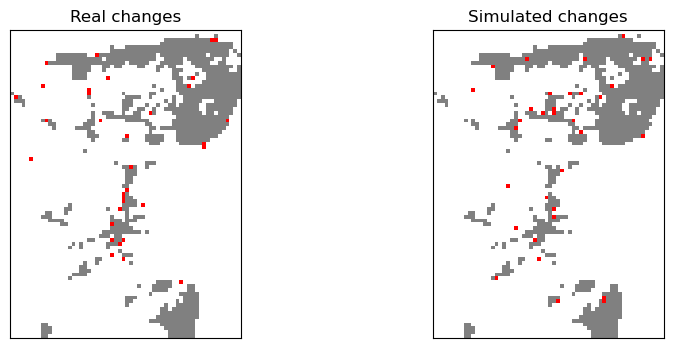

In [20]:
changes_colours = ListedColormap(['none','r'])
cmap = ListedColormap(["none","none", "grey"])

fig, axes = plt.subplots(1,2,figsize=(10,4))

result_plot = categorized_FUA_1990s[index_of_margate].copy()
result_plot[result_plot==-200]=0
show(result_plot, ax=axes[0], transform=out_transforms1975[index_of_margate],cmap=cmap)
previous = categorized_FUA_1975s[index_of_margate].copy()
previous[previous==-200]=0
# result_plot = result_plots[i].copy()
# result_plot[result_plot==-200]=0
changes = result_plot-previous
show(changes,ax=axes[0],cmap=changes_colours,transform=out_transforms1975[index_of_margate])
axes[0].tick_params(labelbottom=False,labelleft=False,axis=u'both', which=u'both',length=0)
axes[0].set_title('Real changes')

result_plot = result.copy()
result_plot[result_plot==-200]=0
show(result_plot, ax=axes[1], transform=out_transforms1975[index_of_margate],cmap=cmap)
previous = categorized_FUA_1975s[index_of_margate].copy()
previous[previous==-200]=0
result_plot = result.copy()
result_plot[result_plot==-200]=0
changes = result_plot-previous
show(changes,ax=axes[1],cmap=changes_colours,transform=out_transforms1975[index_of_margate])
axes[1].tick_params(labelbottom=False,labelleft=False,axis=u'both', which=u'both',length=0)
axes[1].set_title('Simulated changes')

# Appendix
1. Parameters for four scenarios

The original parameters can be found at: https://figshare.com/s/650730f9e6fedc44ac1a   
The parameters by scenarios can be found at: https://doi.org/10.6084/m9.figshare.22194244.v1

In [60]:
# Load the parameters for urban spatial development scenarios projection
# The parameters can be found at: https://figshare.com/s/650730f9e6fedc44ac1a
paths = [ r'results_EU\pattern_kl\Avignon_m_chain2.npy',r'results_EU\pattern_kl\Poitiers_m_chain2.npy',
         r'results_EU\pattern_kl\Belfast_m_chain2.npy',r'results_EU\pattern_kl\Blackwater_m_chain2.npy',
         r'results_EU\pattern_kl\Enschede_m_chain2.npy',r'results_EU\pattern_kl\Utrecht_m_chain2.npy',
         r'results_EU\pattern_kl\Leuven_m_chain2.npy', r'results_EU\pattern_kl\Mons_m_chain2.npy', 
         r'results_EU\pattern_kl\Mönchengladbach_m_chain2.npy',r'results_EU\pattern_kl\Wuppertal_m_chain2.npy']

chains = [np.load(path,allow_pickle=True) for path in paths]
paras_best20_pattern = [chain[0][chain[2].argsort()[:20]] for chain in chains]
seeds_best20_pattern = [chain[1][chain[2].argsort()[:20]] for chain in chains]


In [61]:
paths = [ r'results_EU\changes_kl\Avignon_m_chain2.npy',r'results_EU\changes_kl\Poitiers_m_chain2.npy',
         r'results_EU\changes_kl\Belfast_m_chain2.npy',r'results_EU\changes_kl\Blackwater_m_chain2.npy',
         r'results_EU\changes_kl\Enschede_m_chain2.npy',r'results_EU\changes_kl\Utrecht_m_chain2.npy',
         r'results_EU\changes_kl\Leuven_m_chain2.npy',r'results_EU\changes_kl\Mons_m_chain2.npy', 
         r'results_EU\changes_kl\Mönchengladbach_m_chain2.npy',r'results_EU\changes_kl\Wuppertal_m_chain2.npy']

chains = [np.load(path,allow_pickle=True) for path in paths]
paras_best20_change = [chain[0][chain[2].argsort()[:20]] for chain in chains]
seeds_best20_change = [chain[1][chain[2].argsort()[:20]] for chain in chains]

In [99]:
paras_compact = np.concatenate([paras_best20_pattern[1], paras_best20_pattern[2],paras_best20_change[2]])

In [100]:
seeds_compact = np.concatenate([seeds_best20_pattern[1], seeds_best20_pattern[2],seeds_best20_change[2]])

In [101]:
paras_mediumcompact = np.concatenate([paras_best20_pattern[-1], paras_best20_pattern[4],
                                      paras_best20_pattern[0],paras_best20_pattern[3],
                                      paras_best20_change[1],paras_best20_change[4]])

In [102]:
seeds_mediumcompact = np.concatenate([seeds_best20_pattern[-1], seeds_best20_pattern[4],
                                      seeds_best20_pattern[0],seeds_best20_pattern[3],
                                      seeds_best20_change[1],seeds_best20_change[4]])

In [103]:
paras_mediumdispersed = np.concatenate([paras_best20_pattern[5], paras_best20_pattern[-2],
                                      paras_best20_pattern[-3],paras_best20_change[0],
                                      paras_best20_change[-1],paras_best20_change[5]])

In [104]:
seeds_mediumdispersed = np.concatenate([seeds_best20_pattern[5], seeds_best20_pattern[-2],
                                      seeds_best20_pattern[-3],seeds_best20_change[0],
                                      seeds_best20_change[-1],seeds_best20_change[5]])

In [105]:
paras_dispersed = np.concatenate([paras_best20_pattern[-4], 
                                      paras_best20_change[-4],paras_best20_change[-3],
                                      paras_best20_change[3],paras_best20_change[-2]])

In [106]:
seeds_dispersed = np.concatenate([seeds_best20_pattern[-4], 
                                      seeds_best20_change[-4],seeds_best20_change[-3],
                                      seeds_best20_change[3],seeds_best20_change[-2]])

In [107]:
paras_fourscenarios = [paras_compact,paras_mediumcompact,paras_mediumdispersed,paras_dispersed]
seeds_fourscenarios = [seeds_compact,seeds_mediumcompact,seeds_mediumdispersed,seeds_dispersed]

In [108]:
np.save('paras_fourscenarios.npy',paras_fourscenarios)
np.save('seeds_fourscenarios.npy',seeds_fourscenarios)